# Meme Retrieval Evaluation
This notebook implements IR metrics (MRR, nDCG@K, Precision@K, Recall@K, mAP) for text-to-image retrieval, and provides analysis and visualization including Precision-Recall curves and MRR breakdowns by query length.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

In [2]:
# -------- Metric Functions -------- #

def dcg_at_k(relevances, k):
    relevances = np.asfarray(relevances)[:k]
    return np.sum((2**relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))

def ndcg_at_k(relevances, k):
    dcg = dcg_at_k(relevances, k)
    ideal = dcg_at_k(sorted(relevances, reverse=True), k)
    return dcg / ideal if ideal > 0 else 0.0

def precision_at_k(relevances, k, threshold):
    relevant = [1 if r >= threshold else 0 for r in relevances[:k]]
    return np.sum(relevant) / k

def recall_at_k(relevances, k, threshold):
    total_relevant = sum(1 for r in relevances if r >= threshold)
    if total_relevant == 0:
        return 0.0
    relevant = [1 if r >= threshold else 0 for r in relevances[:k]]
    return np.sum(relevant) / total_relevant

def average_precision(relevances, threshold):
    ap = 0.0
    hit_count = 0
    for i, rel in enumerate(relevances):
        if rel >= threshold:
            hit_count += 1
            ap += hit_count / (i + 1)
    return ap / hit_count if hit_count else 0.0

def reciprocal_rank(relevances, threshold):
    for i, rel in enumerate(relevances):
        if rel >= threshold:
            return 1.0 / (i + 1)
    return 0.0

In [3]:
# -------- Evaluation Function -------- #

def evaluate_group(grouped_df, k_list=[5, 10], threshold=1):
    results = {}
    for k in k_list:
        ndcg_scores = []
        precision_scores = []
        recall_scores = []
        ap_scores = []
        rr_scores = []

        for _, group in grouped_df:
            relevances = group.sort_values('directory').relevance.tolist()
            ndcg_scores.append(ndcg_at_k(relevances, k))
            precision_scores.append(precision_at_k(relevances, k, threshold=threshold))
            recall_scores.append(recall_at_k(relevances, k, threshold=threshold))
            ap_scores.append(average_precision(relevances, threshold=threshold))
            rr_scores.append(reciprocal_rank(relevances, threshold=threshold))

        results[f'nDCG@{k}'] = np.mean(ndcg_scores)
        results[f'Precision@{k}'] = np.mean(precision_scores)
        results[f'Recall@{k}'] = np.mean(recall_scores)
    
    results['MAP'] = np.mean(ap_scores)
    results['MRR'] = np.mean(rr_scores)
    return results

In [4]:
# -------- Load and Evaluate -------- #

def run_evaluation(file_path, k_list=[5, 10, 20], threshold=1):
    df = pd.read_csv(file_path, names=['query', 'relevance', 'directory'])
    grouped = df.groupby('query')
    results = evaluate_group(grouped, k_list=k_list, threshold=threshold)
    print(f"Evaluation results for {file_path}")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")



In [5]:
print("Threshold = 1")
print("-----------")
run_evaluation('test_meme.csv', k_list=[5, 10, 20], threshold = 1)
print("-----------")
run_evaluation('test_template.csv', k_list=[5, 10], threshold = 1)

Threshold = 1
-----------
Evaluation results for test_meme.csv
nDCG@5: 0.6383
Precision@5: 0.8465
Recall@5: 0.2590
nDCG@10: 0.6837
Precision@10: 0.8446
Recall@10: 0.5151
nDCG@20: 0.8411
Precision@20: 0.8255
Recall@20: 1.0000
MAP: 0.8635
MRR: 0.9163
-----------
Evaluation results for test_template.csv
nDCG@5: 0.5008
Precision@5: 0.4960
Recall@5: 0.5233
nDCG@10: 0.7029
Precision@10: 0.4697
Recall@10: 1.0000
MAP: 0.5982
MRR: 0.6558


In [6]:
print("Threshold = 2")
print("-----------")
run_evaluation('test_meme.csv', k_list=[5, 10, 20], threshold = 2)
print("-----------")
run_evaluation('test_template.csv', k_list=[5, 10], threshold = 2)

Threshold = 2
-----------
Evaluation results for test_meme.csv
nDCG@5: 0.6383
Precision@5: 0.4901
Recall@5: 0.2503
nDCG@10: 0.6837
Precision@10: 0.4871
Recall@10: 0.4893
nDCG@20: 0.8411
Precision@20: 0.4869
Recall@20: 0.9802
MAP: 0.5623
MRR: 0.6578
-----------
Evaluation results for test_template.csv
nDCG@5: 0.5008
Precision@5: 0.3714
Recall@5: 0.5021
nDCG@10: 0.7029
Precision@10: 0.3417
Recall@10: 0.9657
MAP: 0.4944
MRR: 0.5509


## Analysis & Visualization

In [7]:
def binarize_relevance(df, threshold):
    df = df.copy()
    df['binary_relevance'] = (df['relevance'] >= threshold).astype(int)
    return df


# Precision-Recall Curve for each dataset
def plot_precision_recall(df, title):
    queries = df['query'].unique()
    y_true = []
    y_scores = []

    for query in queries:
        group = df[df['query'] == query]
        # Binary relevance for PR curve
        bin_rel = group['binary_relevance'].values
        # Simulated scores based on inverse rank (top is more confident)
        score = np.linspace(1, 0, num=len(bin_rel))
        y_true.extend(bin_rel)
        y_scores.extend(score)

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, label=f'{title} (AUC={pr_auc:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    # Track MRR across different query lengths
def compute_mrr_by_query_length(df, threshold):
    df = df.copy()
    df['query_len'] = df['query'].apply(lambda x: len(x.split()))
    mrr_by_len = []

    for length in sorted(df['query_len'].unique()):
        sub_df = df[df['query_len'] == length].groupby('query')
        rr_scores = []

        for _, group in sub_df:
            relevances = group['relevance'].tolist()
            for i, rel in enumerate(relevances):
                if rel >= threshold:
                    rr_scores.append(1.0 / (i + 1))
                    break
            else:
                rr_scores.append(0.0)

        mrr_by_len.append((length, np.mean(rr_scores)))

    return pd.DataFrame(mrr_by_len, columns=["query_length", "MRR"])

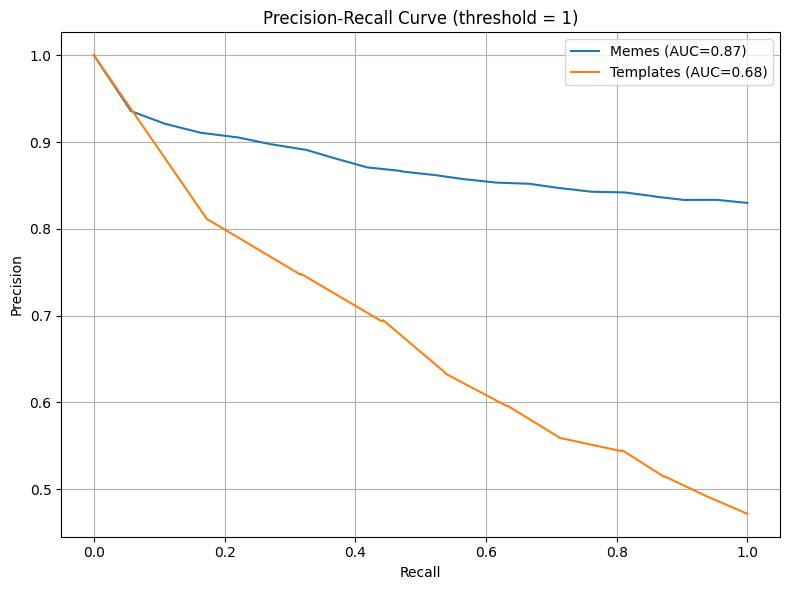

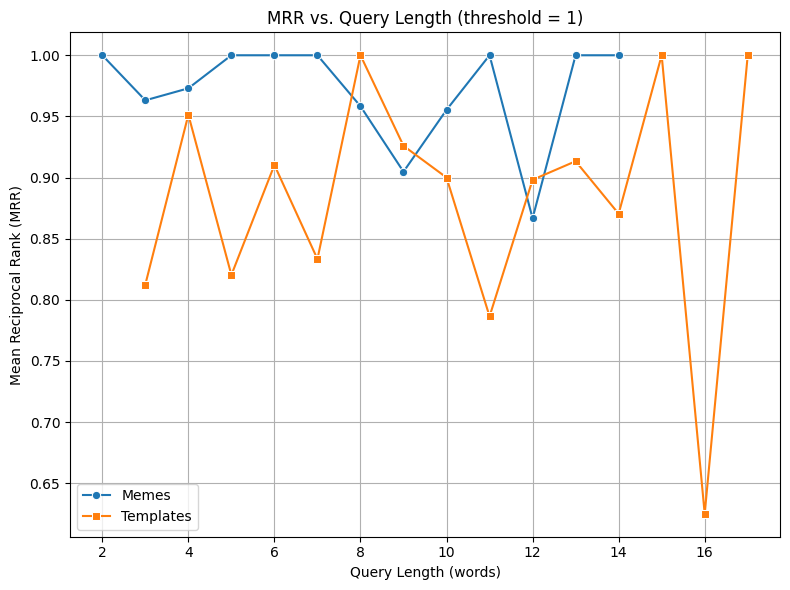

In [8]:
meme_df = pd.read_csv("test_meme.csv", names=['query', 'relevance', 'directory'])
template_df = pd.read_csv("test_template.csv", names=['query', 'relevance', 'directory'])

threshold = 1
meme_df = binarize_relevance(meme_df, threshold)
template_df = binarize_relevance(template_df, threshold)

# --- Plotting ---

# 1. Precision-Recall curves
plt.figure(figsize=(8, 6))
plot_precision_recall(meme_df, "Memes")
plot_precision_recall(template_df, "Templates")
plt.title("Precision-Recall Curve (threshold = 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. MRR by query length
meme_mrr = compute_mrr_by_query_length(meme_df, threshold)
template_mrr = compute_mrr_by_query_length(template_df, threshold)

plt.figure(figsize=(8, 6))
sns.lineplot(data=meme_mrr, x="query_length", y="MRR", marker="o", label="Memes")
sns.lineplot(data=template_mrr, x="query_length", y="MRR", marker="s", label="Templates")
plt.title("MRR vs. Query Length (threshold = 1)")
plt.xlabel("Query Length (words)")
plt.ylabel("Mean Reciprocal Rank (MRR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

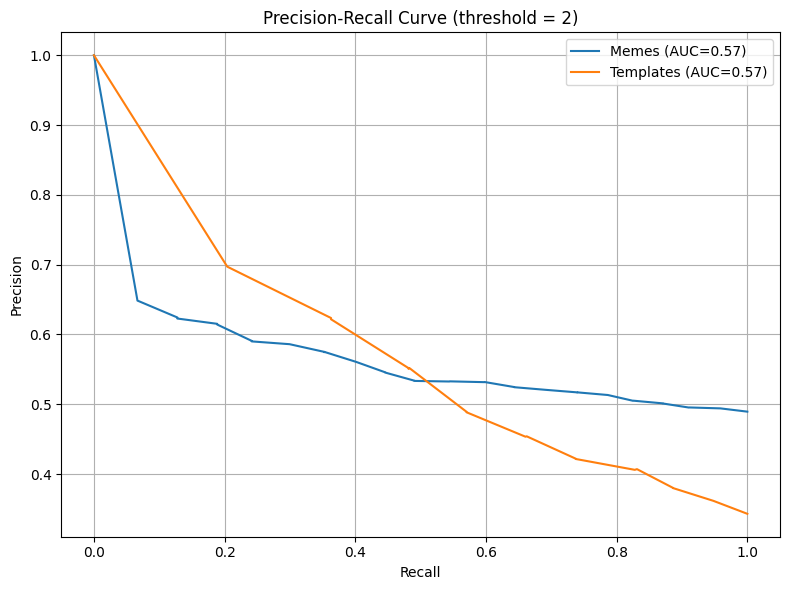

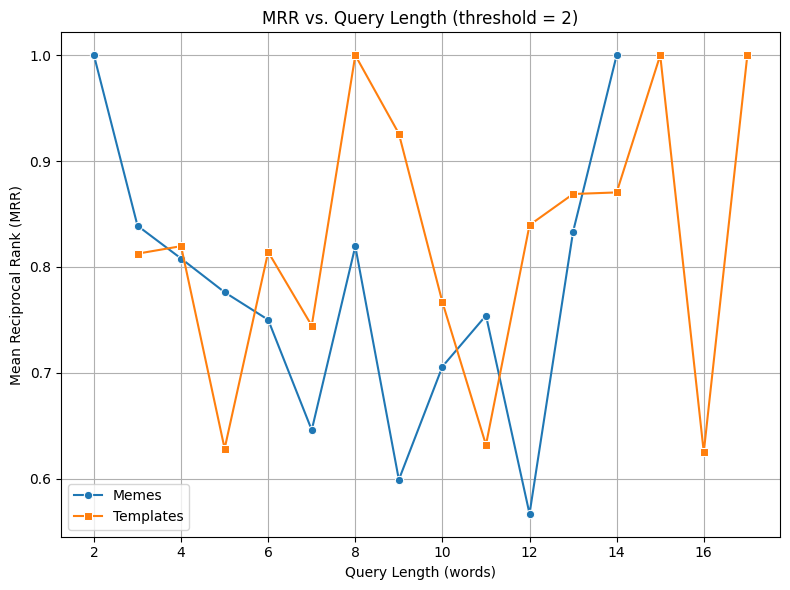

In [9]:
meme_df = pd.read_csv("test_meme.csv", names=['query', 'relevance', 'directory'])
template_df = pd.read_csv("test_template.csv", names=['query', 'relevance', 'directory'])

threshold = 2
meme_df = binarize_relevance(meme_df, threshold)
template_df = binarize_relevance(template_df, threshold)

# --- Plotting ---

# 1. Precision-Recall curves
plt.figure(figsize=(8, 6))
plot_precision_recall(meme_df, "Memes")
plot_precision_recall(template_df, "Templates")
plt.title("Precision-Recall Curve (threshold = 2)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. MRR by query length
meme_mrr = compute_mrr_by_query_length(meme_df, threshold)
template_mrr = compute_mrr_by_query_length(template_df, threshold)

plt.figure(figsize=(8, 6))
sns.lineplot(data=meme_mrr, x="query_length", y="MRR", marker="o", label="Memes")
sns.lineplot(data=template_mrr, x="query_length", y="MRR", marker="s", label="Templates")
plt.title("MRR vs. Query Length (threshold = 2)")
plt.xlabel("Query Length (words)")
plt.ylabel("Mean Reciprocal Rank (MRR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()